In [68]:
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
from torchvision import models, transforms

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)

!git clone https://github.com/Rope-player/pytorch_advanced.git

PyTorch Version:  1.12.1+cu113
Torchvision Version:  0.13.1+cu113
Cloning into 'pytorch_advanced'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 108 (delta 0), reused 0 (delta 0), pack-reused 101
Receiving objects: 100% (108/108), 5.09 MiB | 35.73 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [69]:
%cd "pytorch_advanced"

/content/pytorch_advanced/1_image_classification/pytorch_advanced/1_image_classification/pytorch_advanced/1_image_classification/pytorch_advanced


In [70]:
%cd "1_image_classification"

/content/pytorch_advanced/1_image_classification/pytorch_advanced/1_image_classification/pytorch_advanced/1_image_classification/pytorch_advanced/1_image_classification


ImageNet으로 파라미터를 학습한 VGG-16모델 불러오기.

In [71]:
use_pretrained = True   # 학습된 파라미터 사용.
net = models.vgg16(pretrained = use_pretrained)
net.eval()   # 추론 모드(평가 모드)로 설정

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

VGG-16 모델의 네트워크 구성은 features와 classifier라는 두 모듈로 나누어졌음.

그리고 각 모듈속에 합성곱(Convolution) 층과 전결합(Fully-Connected) 층이 있음.

- VGG-16 모델의 구성

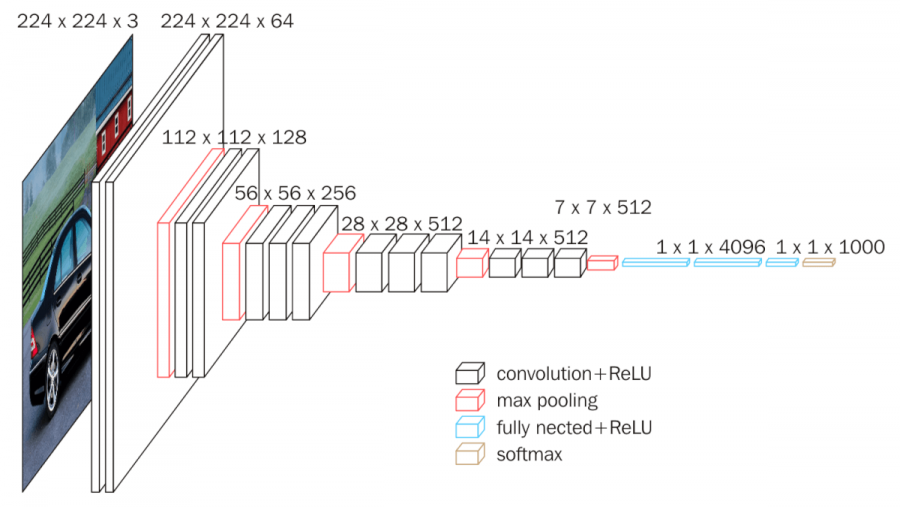

학습된 VGG-16 모델을 읽은 후에는 VGG-16 화상을 입력하는데 필요한 전처리 부분을 작성.

In [72]:
class BaseTransform():
  # reisize: int 
  #   크기 변경 전의 화상 크기
  # mean : (R, G, B)
  #   각 색상 채널의 평균값
  # std : (R, G, B)
  #   각 색상 채널의 표준편차

  def __init__(self, resize, mean, std):
    self.base_transform = transforms.Compose([
        transforms.Resize(resize),        # 짧은 변의 길이가 resize 크기가 된다
        transforms.CenterCrop(resize),    # 화상 중앙을 resize * resize로 자른다
        transforms.ToTensor(),            # 토치 텐서로 변환  
        transforms.Normalize(mean, std)   # 색상 정보의 표준화
    ])
  
  def __call__(self, img):
    return self.base_transform(img)

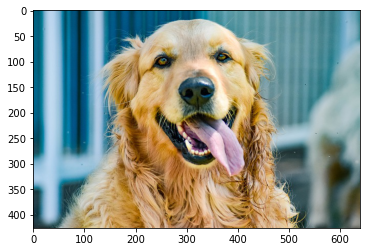

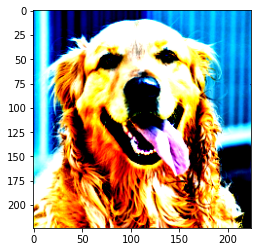

In [73]:
# 1) 화상읽기

image_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)


# 2) 원본 화상 표시
plt.imshow(img)
plt.show()   # 처음 나오는 리트리버(원본)


# 3) 화상 전처리 및 처리된 화상의 표시
resize = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
transform = BaseTransform(resize, mean, std)
img_transformed = transform(img)


# (색상, 높이, 너비)를 (높이, 너비, 색상)으로 변환. 0 ~ 1로 값을 제한하여 표시
# 파이토치와 PIL의 화상요소를 다루는 순서가 다르기때문여 변환해야 함
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0 ,1)

plt.imshow(img_transformed)
plt.show()

In [74]:
#ILSVRC 라벨 정보 읽기. 사전형 변수 생성.

ILSVRC_class_index = json.load(open('./data/imagenet_class_index.json', 'r'))
ILSVRC_class_index

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

In [75]:
# 출력 결과에서 라벨(정답)을 예측하는 후처리 클래스

class ILSVRCPredictor():
  def __init__(self, class_index):
    self.class_index = class_index

    # ILSVRC 데이터 모델의 출력에서 라벨을 구한다.
    # class_index : dictionary >> 클래스 index와 라벨명을 대응시킨 사전형 변수

  def predict_max(self, out):

    # 최대 확률의 ILSVRC 라벨명을 가져온다
    # predicted_label_name : str >> 가장 확률이 높은 라벨명(정답)

    maxid = np.argmax(out.detach().numpy())
    predicted_label_name = self.class_index[str(maxid)][1]

    return predicted_label_name

화상 전처리용 BaseTransform 클래스와 네트워크 출력의 후처리용 ILSVRCPredictor 클래스를 만들었음. 

구성은 아래의 사진과 같음.

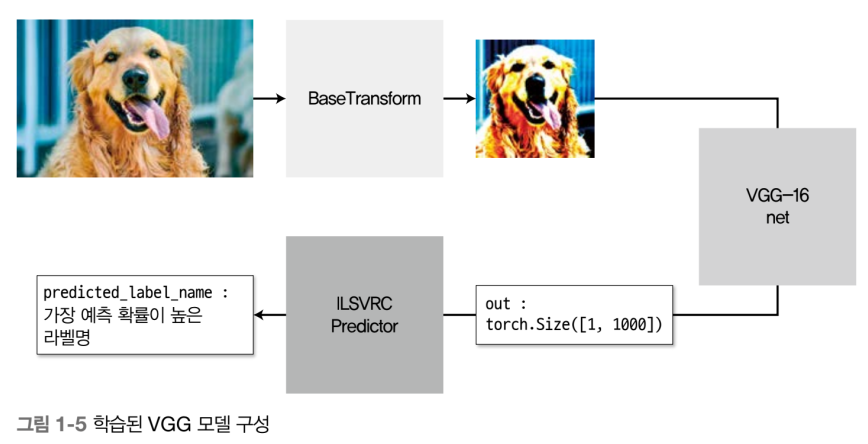

이제 위 흐름을 구현하여 학습된 VGG모델로 화상(사진)을 예측하기.

파이토치 네트워크에 화상을 입력할 때 데이터를 미니배치 형태로 해야함.

`unsqueeze_(0)`를 사용하여 미니 배치의 차원을 추가하기.

In [77]:
# ILSVRC 라벨 정보를 읽어 사전형 변수 생성
ILSVRC_class_index = json.load(open('./data/imagenet_class_index.json', 'r'))

# ILSVRCPredictor 인스턴스 생성
predictor = ILSVRCPredictor(ILSVRC_class_index)

# 입력 화상(사진) 읽기
image_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)   # [높이][너비][색RGB]
transform = BaseTransform(resize, mean, std)
img_transformed = transform(img)
inputs = img_transformed.unsqueeze(0)   # unsqueeze로 [3, 224, 224] 에서 [1, 3, 224, 224]으로 변환

# 모델에 입력하고 출력을 라벨로 변환 
out = net(inputs)   # torch.size[1, 1000]
result = predictor.predict_max(out)

# 결과 출력
print("입력화상의 예측 결과: ", result)

입력화상의 예측 결과:  golden_retriever
